In [1]:
import numpy as np
import numpy.linalg as LA
import jax
import jax.numpy as jnp

import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
from jax.example_libraries import optimizers
from tqdm.notebook import trange
from functools import partial

In [2]:
T = 1.
N = 100
eta = T/N

In [3]:
def Euler(a):
    x = jnp.zeros(N)
    x0 = 1.
    x = x.at[0].set(x0 + eta * a[0] * x0)
    for i in range(N):
        x = x.at[i+1].set(x[i] + eta * a[0] * x[i])
    return x

In [4]:
def gen_dataset(std):
    x_data = jnp.zeros(N)
    for i in range(N):
        if i % 10 == 0:
            x_data = x_data.at[i].set(jnp.exp(2*(eta*i)) + std*np.random.randn())
        else:
            x_data = x_data.at[i].set(jnp.nan)
    return x_data

In [5]:
x_data = gen_dataset(0.5)

In [6]:
df = pd.DataFrame()
t = np.arange(0, T, eta)
df["t"] = t
df["Dataset"] = x_data
df["y = exp(2x)"] = jnp.exp(2*t)

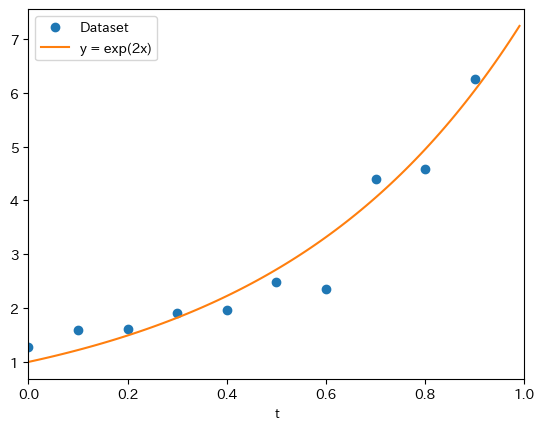

In [7]:
ax = plt.subplot(1,1,1)
df.plot("t", "Dataset", marker= "o", linestyle = "", ax = ax)
df.plot("t", "y = exp(2x)", ax=ax)
plt.xlim([0,1]);

In [8]:
@jax.jit
def DU_Euler(x_data, a):
    x = 1.
    loss = 0
    for i in range(N):
        x += eta * a[0] * x
        if i % 10 == 0:
            loss += (x - x_data[i])**2
    return loss

In [9]:
adam_lr = 0.2
train_itr = 100

opt_init, opt_update, get_params = optimizers.adam(adam_lr)

def train(x_data, a):
    opt_state = opt_init(a)
    for i in range(train_itr):
        value, grads = jax.value_and_grad(DU_Euler, argnums=-1)(x_data, get_params(opt_state))
        opt_state = opt_update(i, grads, opt_state)
        print("\r"+"\rloss:{}".format(value), end=" ")
    return get_params(opt_state)

In [10]:
a_init = jnp.array([1.0])
a_trained = train(x_data, a_init)

loss:1.5588257312774658 

In [11]:
df["DU-Euler"] = Euler(a_trained)

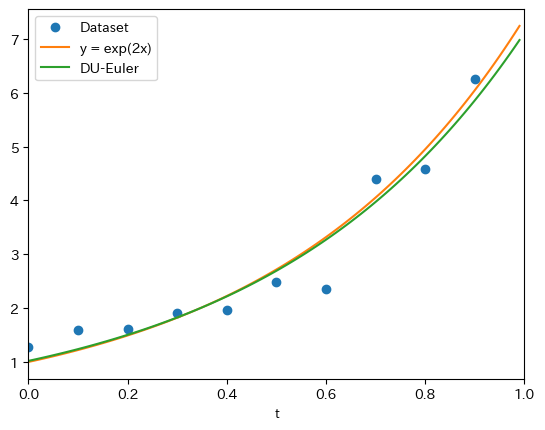

In [13]:
ax = plt.subplot(1,1,1)
df.plot("t", "Dataset", marker= "o", linestyle = "", ax = ax)
df.plot("t", "y = exp(2x)", ax=ax)
df.plot("t", "DU-Euler", ax=ax)
plt.xlim([0,1]);